Basic simulation
----------------
The `grizli` extraction and fitting code can work as a spectrum simulator, indeed spectrum "simulation" goes hand-in-hand with fitting. Though here we consider "simulation" in the sense of predicting what dispersed spectra would look like for a known direct image and assumed target spectrum in the case of, e.g., observation planning.

In [31]:
# for notebook
%matplotlib inline

import os
import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.18)

import numpy as np

import astropy.io.fits as pyfits

# First is local for testing, exception should work
try:
    import grizlidev as grizli
except:
    import grizli

In [32]:
## Initialize the FLT object with just a *direct* image.
sim_g141 = grizli.model.GrismFLT(flt_file=None, direct_image='ibhj34h6q_flt.fits', 
                                 force_grism='G141', pad=0)

ibhj34h6q_flt.fits / Blot reference image: None


In [33]:
## Make a simple detection catalog + segmentation image with photutils.
sim_g141.photutils_detection(detect_thresh=2, grow_seg=5, gauss_fwhm=2., 
                            compute_beams=None,
                            verbose=True, save_detection=True, wcs=None)

ibhj34h6q_flt.fits: photutils.detect_sources (detect_thresh=2.0, grow_seg=5, gauss_fwhm=2.0)
ibhj34h6q_flt.fits: photutils.source_properties
ibhj34h6q_flt.fits: photutils.source_properties - 210 objects
ibhj34h6q_flt.fits: save ibhj34h6q_flt.detect_seg.fits, ibhj34h6q_flt.detect.cat


In [34]:
## Compute the full grism model.
sim_g141.compute_full_model(compute_beams=['A','B','C','D'], verbose=False)

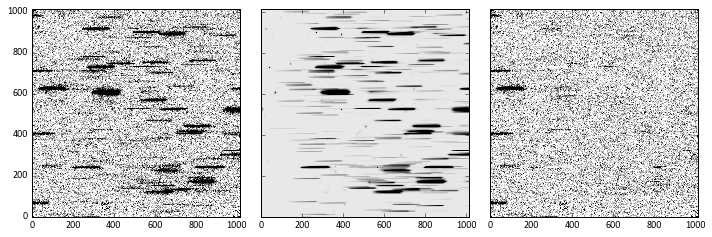

In [35]:
# Compare to the actual G141 exposure
g141 = pyfits.open('ibhj34h8q_flt.fits')    
fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(g141['SCI'].data, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')

ax = fig.add_subplot(132)
ax.imshow(sim_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')

ax = fig.add_subplot(133)
ax.imshow(g141['SCI'].data - sim_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')

for ax in fig.axes[1:]:
    ax.set_yticklabels([])
    
fig.tight_layout()

In [36]:
## Now simulate a g102 spectrum
sim_g102 = grizli.model.GrismFLT(flt_file=None, direct_image='ibhj34h6q_flt.fits', 
                                 force_grism='G102', pad=0)

ibhj34h6q_flt.fits / Blot reference image: None


In [37]:
# Load segmentation image and catalog we just made
sim_g102.load_photutils_detection()
sim_g102.compute_full_model(compute_beams=['A','B','C','D'], verbose=False)

In [38]:
## Consider an object near the center of the image
dr = np.sqrt((sim_g141.catalog['xcentroid']-579)**2+(sim_g141.catalog['ycentroid']-522)**2)    
ix = np.argmin(dr)
id = sim_g141.catalog['id'][ix]
x0 = sim_g141.catalog['xcentroid'][ix]+1
y0 = sim_g141.catalog['ycentroid'][ix]+1
print 'id=%d, (x,y)=(%.1f, %.1f)' %(id, x0, y0)

id=107, (x,y)=(579.9, 522.3)


In [39]:
## Spectrum cutouts
reload(grizli.grism); reload(grizli.model); reload(grizli)
beam_g102 = grizli.model.BeamCutout(id=id, x=x0, y=y0, cutout_dimensions=[18,18], 
                                    conf=sim_g102.conf, GrismFLT=sim_g102)
beam_g141 = grizli.model.BeamCutout(id=id, x=x0, y=y0, cutout_dimensions=[18,18], 
                                    conf=sim_g141.conf, GrismFLT=sim_g141)

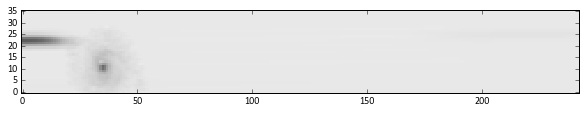

In [40]:
## Contamination coutouts of spectra around the object of interest
for beam, sim in zip([beam_g102, beam_g141], [sim_g102, sim_g141]):
    beam.compute_model(beam.thumb, id=beam.id) # flat-spectrum model 
    beam.contam = beam.get_cutout(sim.model) - beam.model # already in sim.model, take it out
    
plt.imshow(beam_g102.contam, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

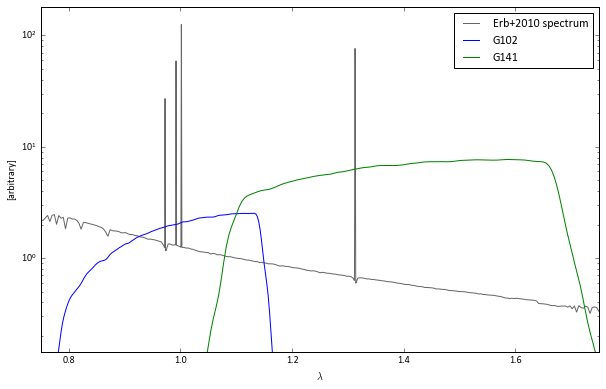

In [41]:
## Example spectrum, low metallicity star-forming galaxy with strong lines
## after the object described by Erb et al. (2010)
spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
erb = np.loadtxt(spectrum_file, unpack=True)
z = 1.0 # test redshift

# show the spectrum and grism passbands
plt.plot(erb[0]*(1+z)/1.e4, erb[1], label='Erb+2010 spectrum', color='0.4')
plt.semilogy()
plt.xlim(0.75,1.75); plt.ylim(4e-4*erb[1].max(),0.5*erb[1].max())
plt.xlabel(r'$\lambda$'); plt.ylabel(r'[arbitrary]')
plt.plot(beam_g102.lam/1.e4, beam_g102.ysens, label='G102')
plt.plot(beam_g141.lam/1.e4, beam_g141.ysens, label='G141')
plt.legend()

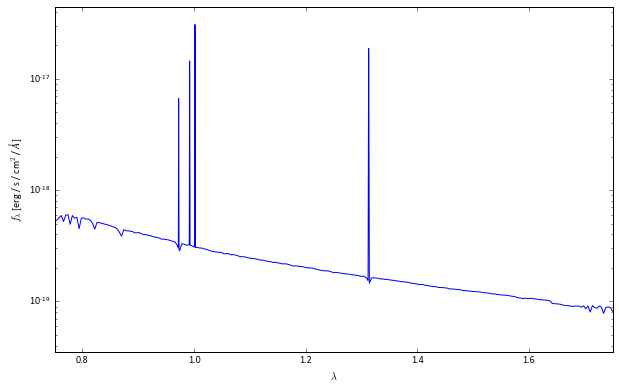

In [42]:
## Use PySynphot to adjust the flux normalization of the models
import pysynphot as S
spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
# Normalize to AB = 24 in WFC3/IR F160W
ABnorm = 24.0
spec = spec.redshift(z).renorm(ABnorm, 'ABMag', S.ObsBandpass('wfc3,ir,f160w'))

# spec.flux now has units of erg / s / cm2 / A
plt.plot(spec.wave/1.e4, spec.flux)
plt.semilogy()
plt.xlim(0.75,1.75); plt.ylim(4e-4*spec.flux.max(),0.5*spec.flux.max())
plt.xlabel(r'$\lambda$'); plt.ylabel(r'$f_\lambda$ [erg / s / cm$^2$ / $\AA$]')

In [43]:
## Compute the models
# The attribute `beam_g102.total_flux` forces the dispersed spectrum to have the 
# same units as the input model, which we normalized above, integrated over the object
# morphology. 
# Without specifying the normalization term in the denominator as below, the `compute_model` 
# function implicitly assumes that the 1D input model spectrum is normalized to have a 
# flux density of unity integrated over the direct image bandpass.
beam_g102.compute_model(beam_g102.thumb, id=id, 
                        xspec=spec.wave, yspec=spec.flux/beam_g102.total_flux)    
beam_g141.compute_model(beam_g141.thumb, id=id, 
                        xspec=spec.wave, yspec=spec.flux/beam_g141.total_flux)

In [44]:
## Test that the computed models have the same total countrate as computed by PySynphot
obs_g102 = S.Observation(spec, S.ObsBandpass('wfc3,ir,g102'))
obs_g141 = S.Observation(spec, S.ObsBandpass('wfc3,ir,g141'))
print 'Total spectrum countrates across the bandpass (e-/s)'
print 'G102:  grizli = %.2f, pysynphot = %.2f, ratio = %.3f' %(beam_g102.model.sum(), 
                        obs_g102.countrate(), beam_g102.model.sum()/obs_g102.countrate())
print 'G141:  grizli = %.2f, pysynphot = %.2f, ratio = %.3f' %(beam_g141.model.sum(), 
                        obs_g141.countrate(), beam_g141.model.sum()/obs_g141.countrate())

# The two agree within a few percent with this test, the difference appears to come from
# some inconsistency between the PySynphot throughput table and the aXe sensitivity curves, 
# since the latter must be multiplied by a factor of delta(wave)-per-pixel to get flux 
# density units

Total spectrum countrates across the bandpass (e-/s)
G102:  grizli = 10.21, pysynphot = 10.00, ratio = 1.021
G141:  grizli = 13.60, pysynphot = 13.40, ratio = 1.015


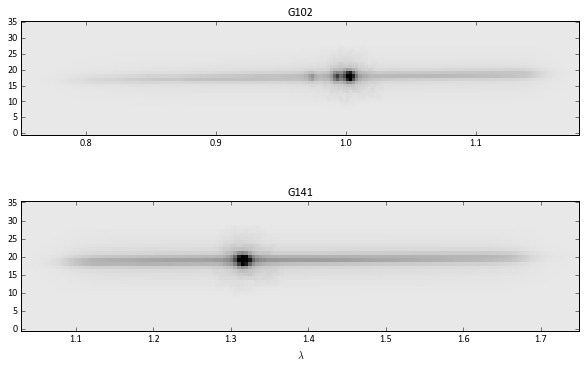

In [45]:
## Show the 2D models
fig = plt.figure()

# G102
ax = fig.add_subplot(211)
ax.set_title('G102')
ax.imshow(beam_g102.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
beam_g102.twod_axis_labels(limits=[0.7,1.25,0.1], wscale=1.e4, mpl_axis=ax)
beam_g102.twod_xlim(0.75,1.18, wscale=1.e4, mpl_axis=ax)

# G141
ax = fig.add_subplot(212)
ax.set_title('G141')
ax.imshow(beam_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
beam_g141.twod_axis_labels(limits=[1.0,1.8,0.1], wscale=1.e4, mpl_axis=ax)
beam_g141.twod_xlim(1.03,1.75, wscale=1.e4, mpl_axis=ax)
ax.set_xlabel(r'$\lambda$')

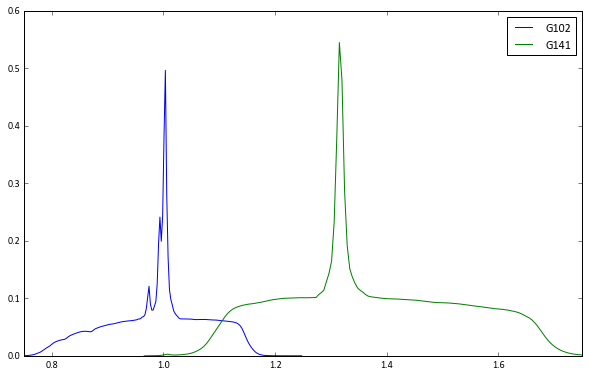

In [46]:
## Plot 1D extractions of the models (error array here is meaningless)
w, f, e = beam_g102.optimal_extract(beam_g102.model, bin=0)
plt.plot(w/1.e4, f, label='G102')

w, f, e = beam_g141.optimal_extract(beam_g141.model, bin=0)
plt.plot(w/1.e4, f, label='G141')
    
plt.xlim(0.75,1.75)
plt.legend()

In [47]:
## Simple add (2D) noise to the G141 spectrum
sky_countrate = 1. # e-/s
texp = 1000.       # s
rn = 20.           # readnoise, e-
rms = np.sqrt(sky_countrate*texp+rn)/texp

np.random.seed(1)
twod_noise = np.random.normal(size=beam_g141.model.shape)*rms

Chi2 = 196.1, dof=183, Chi2_nu = 1.07, rms=1.026


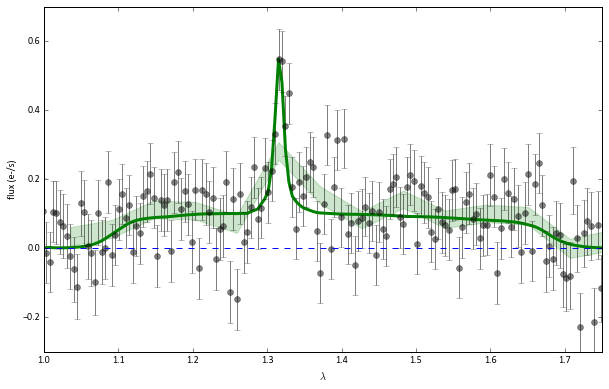

In [48]:
### 1D extraction with noise
# get uncertainties correct
beam_g141.ivar = np.ones_like(beam_g141.model)/rms**2

# no noise
w0, f0, e0 = beam_g141.optimal_extract(beam_g141.model, bin=0)
plt.plot(w0/1.e4, f0, label='G141', color='green', linewidth=3)

# with noise
w, f, e = beam_g141.optimal_extract(beam_g141.model + twod_noise, bin=0)
plt.errorbar(w/1.e4, f, e, label='G141', color='k', marker='o', linestyle='None', alpha=0.5)

# check uncertainties, RMS should be about unity, chi2 should be about 1
msk = np.isfinite(f)
chi2 = np.sum(((f-f0)**2/e**2)[msk])
print 'Chi2 = %.1f, dof=%d, Chi2_nu = %.2f, rms=%.3f' %(chi2, msk.sum()-1, chi2/(msk.sum()-1), 
                                                        np.std(((f-f0)/e)[msk]))

# demo with binning
w, f, e = beam_g141.optimal_extract(beam_g141.model + twod_noise, bin=12)
plt.fill_between(w/1.e4, f+e, f-e, color='green', alpha=0.2)

plt.plot([1,1.8],[0,0], linestyle='--')
plt.xlim(1.0, 1.75); plt.ylim(-0.3,0.7)
plt.xlabel(r'$\lambda$'); plt.ylabel('flux (e-/s)')

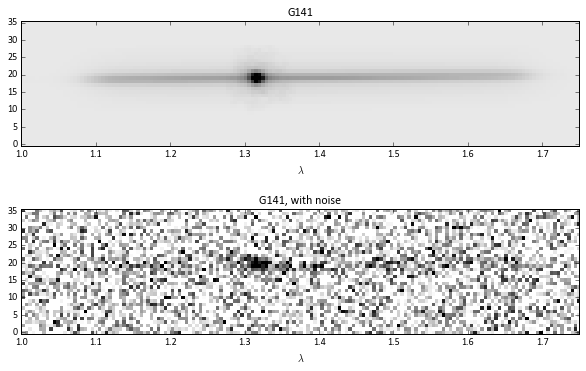

In [49]:
## Show the 2D models
fig = plt.figure()

# G141
ax = fig.add_subplot(211)
ax.set_title('G141')
ax.imshow(beam_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# G141, with noise
ax = fig.add_subplot(212)
ax.set_title('G141, with noise')
ax.imshow(beam_g141.model + twod_noise, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
for ax in fig.axes:
    beam_g141.twod_axis_labels(limits=[1.0,1.8,0.1], wscale=1.e4, mpl_axis=ax)
    beam_g141.twod_xlim(1.0,1.75, wscale=1.e4, mpl_axis=ax)
    ax.set_xlabel(r'$\lambda$')